# Stabla odlucivanja

In [45]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import numpy as np
from termcolor import colored

Ucitavanje podataka:

In [46]:
data=pd.read_csv("C:/Users/Administrator/2023_Data_Mining_Coffee_Quality_Dataset/cleaned_data.csv")
data.head()

,Unnamed: 0,Species,Country.of.Origin,Harvest.Year,Variety,Processing.Method,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_mean_meters,Total.Cup.Points
0,0,0,8,5,5,4,0,0.0,2,0,2075.0,9.0
1,1,0,8,5,15,4,0,0.0,2,1,2075.0,9.0
2,2,0,9,3,2,4,0,0.0,2,0,1700.0,9.0
3,3,0,8,5,5,0,0,0.0,2,2,2000.0,9.0
4,4,0,8,5,15,4,0,0.0,2,2,2075.0,9.0


In [47]:
data.drop("Unnamed: 0",axis=1,inplace=True)

Podela na ulazne i ciljne atribute:

In [48]:
Y=data["Total.Cup.Points"]
X=data.drop("Total.Cup.Points",axis=1)
feature_names=X.columns
X.head()

,Species,Country.of.Origin,Harvest.Year,Variety,Processing.Method,Category.One.Defects,Quakers,Color,Category.Two.Defects,altitude_mean_meters
0,0,8,5,5,4,0,0.0,2,0,2075.0
1,0,8,5,15,4,0,0.0,2,1,2075.0
2,0,9,3,2,4,0,0.0,2,0,1700.0
3,0,8,5,5,0,0,0.0,2,2,2000.0
4,0,8,5,15,4,0,0.0,2,2,2075.0


In [49]:
Y.unique()

array([9., 8., 7., 6., 5., 4.])

Podaci su prilicno nebalansirani

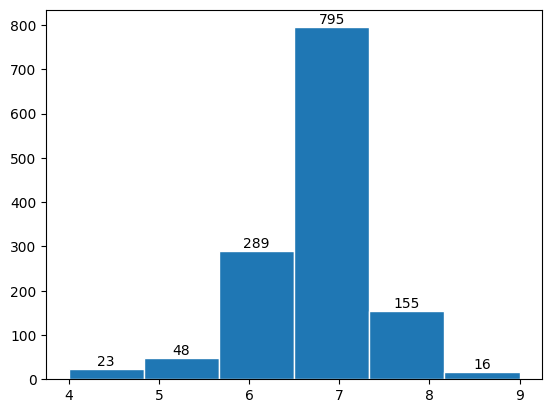

In [50]:
#kod preuzet iz materijala za vezbe
freq, bins, _ = plt.hist(Y,edgecolor='white', bins=6)

bin_centers=np.diff(bins)*0.5+bins[:-1]
for fr, x in zip(freq,bin_centers):
    height=int(fr)
    plt.annotate("{}".format(height),xy=(x,height),xytext = (0,0.2),textcoords = "offset points", ha = 'center', va = 'bottom')

plt.show()

Podela na trening i test skup

In [51]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, stratify=Y, random_state=42)
print(X_train.shape, X_test.shape)

(888, 10) (438, 10)


Pomocne funkcije

In [52]:
#kod preuzet iz materijala
from collections import Counter
from sklearn.decomposition import PCA

def resample(sampler, X, Y):
    X_resampled, y_resampled = sampler.fit_resample(X, Y)
    print(colored("Number of instances before resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(Y).items()), "green"))
    print(colored("Number of instances after  resampling with {} : {}. ".format(type(sampler).__name__,\
                                                                           Counter(y_resampled).items()), "blue"))
    return X_resampled, y_resampled
    

In [53]:
def visualize(X, X_resampled, Y, Y_resampled, x_opacity=0.5):
    """
        x_opacity - [0, 1] -> prozirnost elemenata klase (podešavati u odnosu na to da li prikazujemo samo 1 klasu ili obe)
    """
    
    #Da bismo vizuelizovali, iskoristicemo PCA da smanjimo na 2 dimenzije
    
    pca = PCA(n_components=2)
    pca.fit(X)
    
    X_pca = pca.transform(X)
    X_resampled_pca = pca.transform(X_resampled) 
    
    X_stacked = [X_pca, X_resampled_pca]
    Y_stacked = [Y, y_resampled]
    
    fig = plt.figure(figsize=(20, 5))
    
    for i in range(2):
        ax = plt.subplot(1, 2, i + 1)
        colors = ['b' if y == -1 else 'r' for y in Y_stacked[i]]
        alpha = [x_opacity if y == -1 else 1 - x_opacity for y in Y_stacked[i]]
        plt.scatter(X_stacked[i][:, 0], X_stacked[i][:, 1], c=colors, alpha=alpha)
        plt.title('{} resampling'.format("After" if i else "Before"), c = 'blue' if i else 'green')
    plt.show()

In [54]:
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced


def report_imbalanced(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("Accuracy: {}".format(accuracy_score(y,y_pred)))
    print("---------------------------------------------------------------------------------")
    print(classification_report_imbalanced(y, y_pred, zero_division=True))
    print("---------------------------------------------------------------------------------")
    
    print(colored("Confusion matrix for model {} on {} data ".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(pd.DataFrame(confusion_matrix(y, y_pred),columns=[4,5,6,7,8,9],index=[4,5,6,7,8,9]))
    print("---------------------------------------------------------------------------------")

In [55]:
def train_and_evaluate_model(X_train, Y_train, X_test, Y_test):
    model = DecisionTreeClassifier(max_depth=6, min_samples_split=5, criterion='gini')
    model.fit(X_train, Y_train)
    report_imbalanced(model, X_train, Y_train,"training")
    report_imbalanced(model, X_test, Y_test,"test")
    return model

In [56]:
def plot_decision_tree(model, feature_names):
    plt.figure(figsize=(7, 7))
    plot_tree(model, class_names=['4', '5','6','7','8','9'], feature_names=feature_names, filled=True)
    plt.title("Decision tree of depth {} with {} nodes".format(model.get_depth(), model.get_n_leaves()))

    plt.show()
    print("---------------------------------------------------------------------------------")
    print(colored("Parameters of model {}".format(type(model).__name__), "green"))
    for k, v in model.get_params().items():
        print(colored(k, 'blue'), v)
    
    print("---------------------------------------------------------------------------------")

Pogledajmo kako se ponasa model pre nego sto balansiramo klase

In [57]:
model_dtc=train_and_evaluate_model(X_train,Y_train,X_test,Y_test)

Classification report for model DecisionTreeClassifier on training data
Accuracy: 0.6463963963963963
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.40      0.13      1.00      0.20      0.36      0.12        15
        5.0       0.75      0.09      1.00      0.17      0.31      0.09        32
        6.0       0.52      0.12      0.97      0.19      0.34      0.11       194
        7.0       0.65      0.97      0.21      0.78      0.45      0.21       532
        8.0       0.82      0.26      0.99      0.39      0.51      0.24       104
        9.0       1.00      0.27      1.00      0.43      0.52      0.25        11

avg / total       0.64      0.65      0.52      0.57      0.42      0.19       888

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 


Ocekivani rezultati - nedominante klase su skroz izbacene 

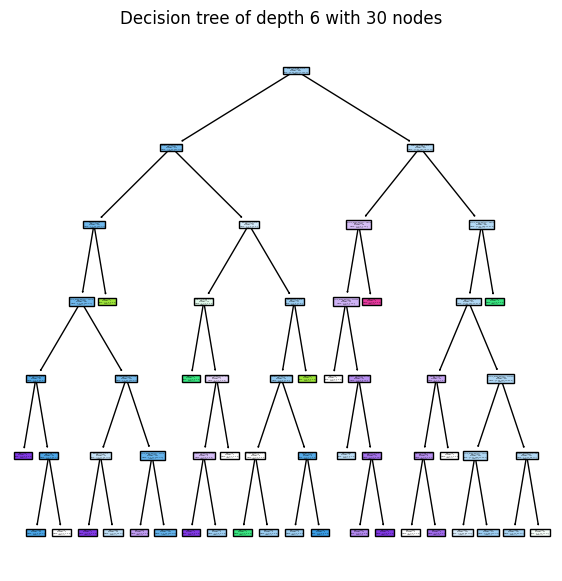

---------------------------------------------------------------------------------
Parameters of model DecisionTreeClassifier
ccp_alpha 0.0
class_weight None
criterion gini
max_depth 6
max_features None
max_leaf_nodes None
min_impurity_decrease 0.0
min_samples_leaf 1
min_samples_split 5
min_weight_fraction_leaf 0.0
random_state None
splitter best
---------------------------------------------------------------------------------


In [58]:
plot_decision_tree(model_dtc,feature_names.tolist())

In [59]:
# normalizacija
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

#### Balansiranje


In [60]:
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=42)

Number of instances before resampling with SMOTEENN : dict_items([(8.0, 104), (7.0, 532), (6.0, 194), (4.0, 15), (9.0, 11), (5.0, 32)]). 
Number of instances after  resampling with SMOTEENN : dict_items([(4.0, 467), (5.0, 425), (6.0, 192), (7.0, 123), (8.0, 296), (9.0, 488)]). 


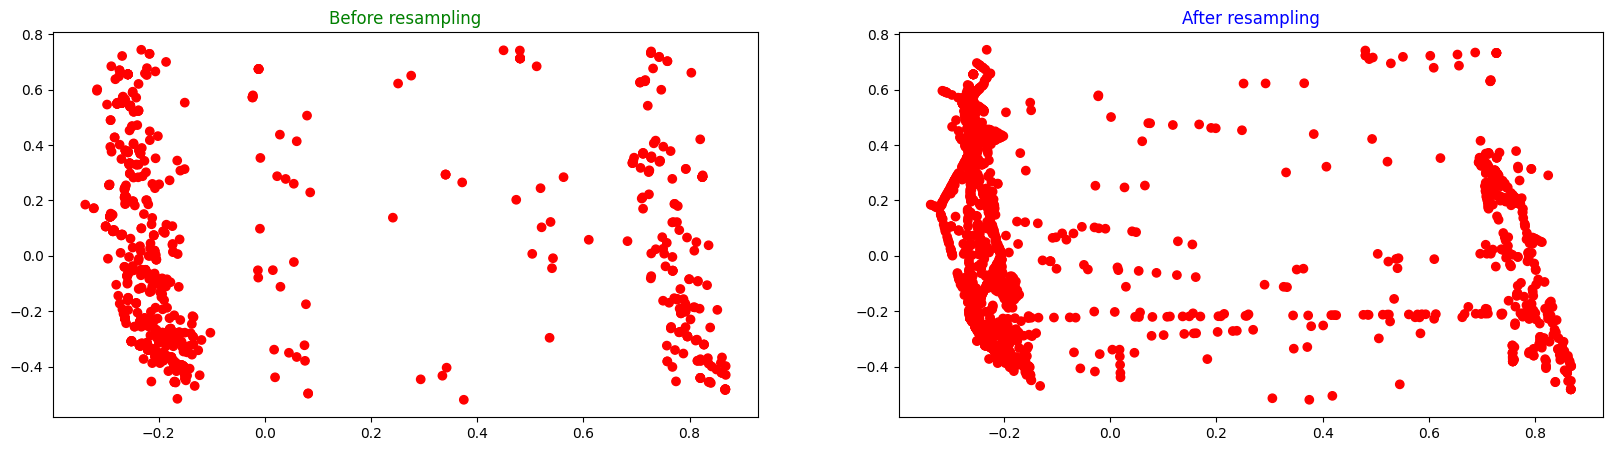

In [61]:
X_resampled, y_resampled = resample(smoteenn, X_train, Y_train)
visualize(X_train, X_resampled, Y_train, y_resampled, 0)

In [62]:
model_smote = train_and_evaluate_model(X_resampled, y_resampled, X_test, Y_test)

Classification report for model DecisionTreeClassifier on training data
Accuracy: 0.8422903063787042
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.94      0.97      0.98      0.96      0.98      0.95       467
        5.0       0.83      0.84      0.95      0.84      0.90      0.80       425
        6.0       0.62      0.60      0.96      0.61      0.76      0.56       192
        7.0       0.87      0.54      0.99      0.66      0.73      0.51       123
        8.0       0.73      0.67      0.96      0.70      0.80      0.62       296
        9.0       0.89      1.00      0.96      0.94      0.98      0.96       488

avg / total       0.84      0.84      0.97      0.84      0.90      0.81      1991

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 


Znacaj atributa u formiranju modela

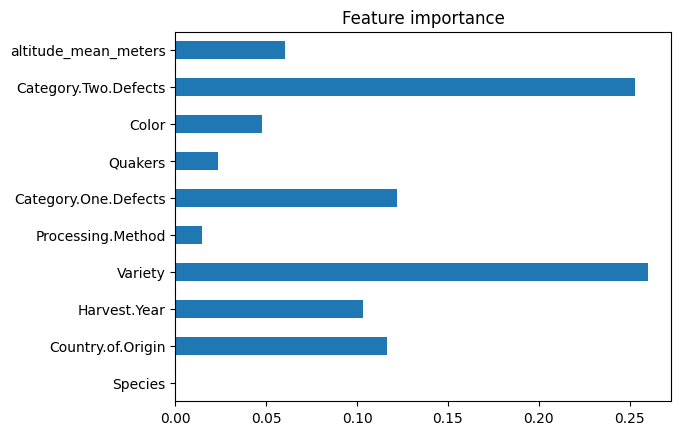

In [63]:
pd.Series(model_smote.feature_importances_, index=feature_names).plot.barh()
plt.title("Feature importance")
plt.show()

#### Podesavanje hiper-parametara

In [64]:
from sklearn.model_selection import GridSearchCV

In [65]:
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2,4,6,8],
          'min_samples_split' : [2,5,8,10]
         }

In [66]:
estimator = GridSearchCV(DecisionTreeClassifier(), param_grid=params, cv=5)

In [67]:
estimator.fit(X_resampled, y_resampled)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8],
                         'min_samples_split': [2, 5, 8, 10]})

In [68]:
print(estimator.best_params_)
print(estimator.best_score_)


{'criterion': 'gini', 'max_depth': 8, 'min_samples_split': 2}
0.8769373181697964


In [69]:
report_imbalanced(estimator.best_estimator_, X_resampled, y_resampled)

Classification report for model DecisionTreeClassifier on training data
Accuracy: 0.9326971371170266
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       1.00      0.99      1.00      0.99      0.99      0.99       467
        5.0       0.92      0.96      0.98      0.94      0.97      0.94       425
        6.0       0.91      0.73      0.99      0.81      0.85      0.71       192
        7.0       0.96      0.77      1.00      0.86      0.88      0.75       123
        8.0       0.88      0.89      0.98      0.89      0.93      0.87       296
        9.0       0.91      1.00      0.97      0.95      0.98      0.97       488

avg / total       0.93      0.93      0.98      0.93      0.96      0.91      1991

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on training data 


In [70]:
report_imbalanced(estimator.best_estimator_, X_test, Y_test, "test")

Classification report for model DecisionTreeClassifier on test data
Accuracy: 0.2579908675799087
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.06      0.25      0.92      0.09      0.48      0.22         8
        5.0       0.09      0.50      0.82      0.16      0.64      0.39        16
        6.0       0.28      0.18      0.87      0.22      0.40      0.15        95
        7.0       0.64      0.23      0.81      0.34      0.43      0.17       263
        8.0       0.21      0.45      0.77      0.28      0.59      0.34        51
        9.0       0.06      0.60      0.89      0.11      0.73      0.52         5

avg / total       0.47      0.26      0.82      0.29      0.45      0.20       438

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
--------

Jako losi rezultati

#### Random forest

In [71]:
from sklearn.ensemble import RandomForestClassifier

params_grid={ 'n_estimators': [100, 200, 300],
                'max_depth': [2, 4 , 6, 8, 10]
                }
estimator2=GridSearchCV(RandomForestClassifier(),param_grid=params_grid)



In [72]:
estimator2.fit(X_resampled,y_resampled)

GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [100, 200, 300]})

In [73]:
print(estimator2.best_score_)
print(estimator2.best_params_)


0.951778944849561
{'max_depth': 10, 'n_estimators': 300}


In [74]:
report_imbalanced(estimator2.best_estimator_, X_resampled, y_resampled)

Classification report for model RandomForestClassifier on training data
Accuracy: 0.9959819186338523
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       1.00      1.00      1.00      1.00      1.00      1.00       467
        5.0       1.00      1.00      1.00      1.00      1.00      1.00       425
        6.0       1.00      0.99      1.00      1.00      1.00      0.99       192
        7.0       1.00      0.98      1.00      0.99      0.99      0.97       123
        8.0       0.99      0.99      1.00      0.99      0.99      0.99       296
        9.0       0.99      1.00      1.00      1.00      1.00      1.00       488

avg / total       1.00      1.00      1.00      1.00      1.00      0.99      1991

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on training data 


In [75]:
report_imbalanced(estimator2.best_estimator_, X_test, Y_test)

Classification report for model RandomForestClassifier on training data
Accuracy: 0.3378995433789954
---------------------------------------------------------------------------------
                   pre       rec       spe        f1       geo       iba       sup

        4.0       0.00      0.00      0.92      1.00      0.00      0.00         8
        5.0       0.09      0.38      0.86      0.15      0.57      0.31        16
        6.0       0.27      0.26      0.80      0.26      0.46      0.20        95
        7.0       0.70      0.32      0.79      0.44      0.50      0.24       263
        8.0       0.30      0.57      0.83      0.39      0.69      0.46        51
        9.0       0.12      0.60      0.95      0.19      0.75      0.55         5

avg / total       0.52      0.34      0.80      0.39      0.51      0.26       438

---------------------------------------------------------------------------------
Confusion matrix for model RandomForestClassifier on training data 


#### Poredjenje modela

In [76]:
#Poredimo model_dtc model_smote, estimator.best_estimator_ i estimator2.best_estimator_
# koristimo one vs rest strategiju za multiklasno poredjenje

In [77]:
from sklearn.preprocessing import LabelBinarizer

label_binarizer = LabelBinarizer().fit(Y_train)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape

(438, 6)

In [78]:
klase=label_binarizer.classes_
klase

array([4., 5., 6., 7., 8., 9.])

In [79]:
from sklearn.metrics import roc_auc_score

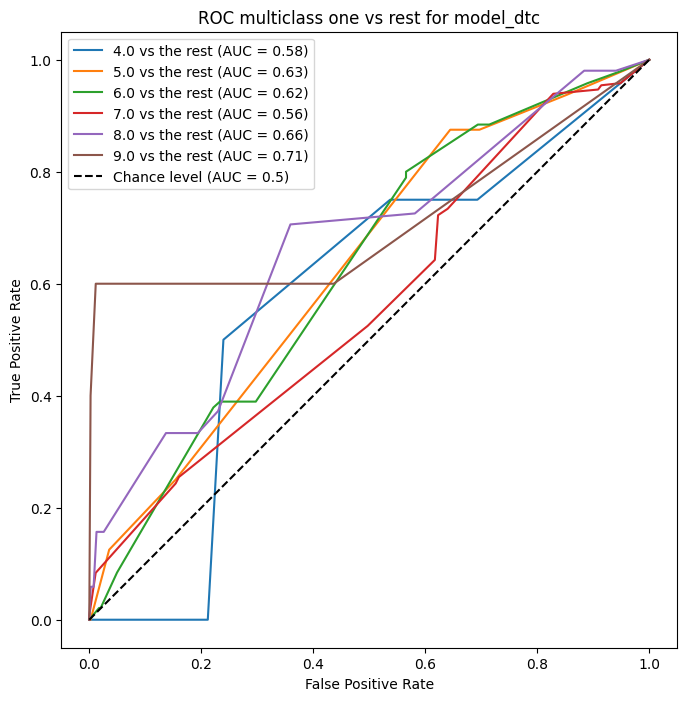

In [80]:
#scikit learn

y_score = model_dtc.fit(X_train, Y_train).predict_proba(X_test)
from itertools import cycle
from sklearn.metrics import RocCurveDisplay
fig, ax=plt.subplots(figsize=(8,8))
colors = cycle(["aqua", "darkorange", "cornflowerblue","magenta","green","red"])
for c in klase:
    class_of_interest = c
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        plot_chance_level=(class_id==5),
        ax=ax
    )
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC multiclass one vs rest for model_dtc")
plt.legend()
plt.show()
   
    


In [81]:
macro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)
micro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
weighted_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Macro average auc score: {macro_avg}")
print(f"Micro average auc score: {micro_avg}")
print(f"Weightedaverage auc score: {weighted_avg}")

Macro average auc score: 0.6286307484896986
Micro average auc score: 0.8571651967223368
Weightedaverage auc score: 0.5935783470889315


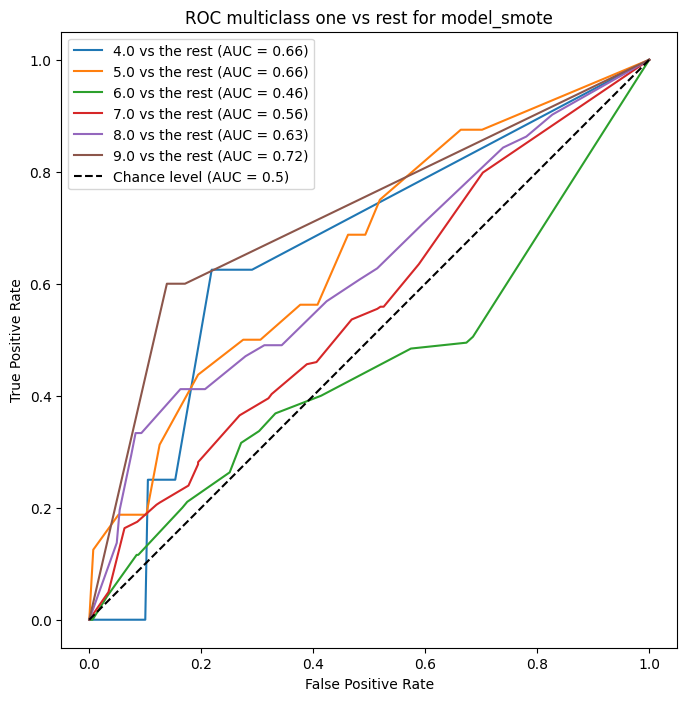

In [82]:
label_binarizer = LabelBinarizer().fit(y_resampled)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape
y_score = model_smote.fit(X_resampled, y_resampled).predict_proba(X_test)

fig, ax=plt.subplots(figsize=(8,8))
#colors = cycle(["aqua", "darkorange", "cornflowerblue","magenta","green","red"])
for c in klase:
    class_of_interest = c
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        plot_chance_level=(class_id==5),
        ax=ax
    )
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC multiclass one vs rest for model_smote")
plt.legend()
plt.show()

In [83]:
macro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)
micro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
weighted_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Macro average auc score: {macro_avg}")
print(f"Micro average auc score: {micro_avg}")
print(f"Weightedaverage auc score: {weighted_avg}")

Macro average auc score: 0.6154135231091699
Micro average auc score: 0.6224505327245053
Weightedaverage auc score: 0.5536694265225378


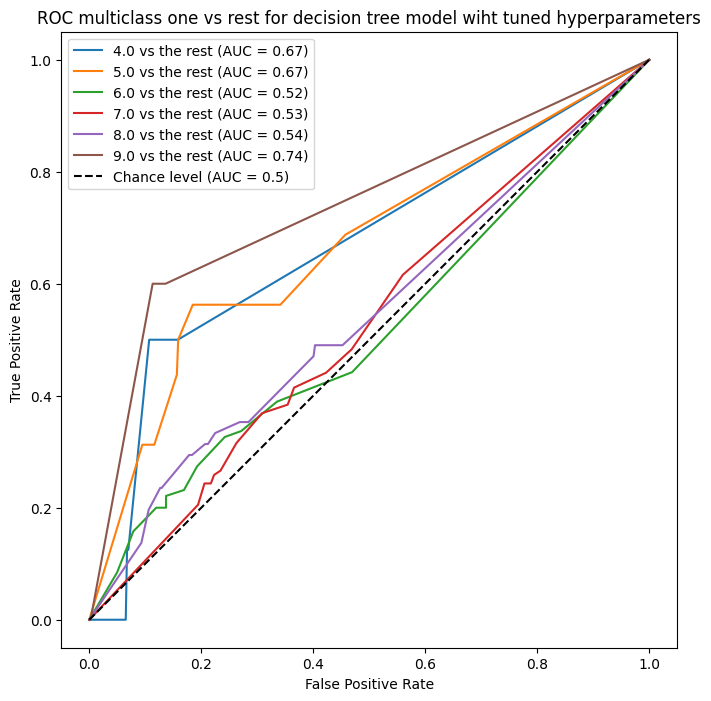

In [84]:
label_binarizer = LabelBinarizer().fit(y_resampled)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape
y_score = estimator.best_estimator_.fit(X_resampled, y_resampled).predict_proba(X_test)

fig, ax=plt.subplots(figsize=(8,8))
#colors = cycle(["aqua", "darkorange", "cornflowerblue","magenta","green","red"])
for c in klase:
    class_of_interest = c
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        plot_chance_level=(class_id==5),
        ax=ax
    )
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC multiclass one vs rest for decision tree model wiht tuned hyperparameters")
plt.legend()
plt.show()

In [85]:
macro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)
micro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
weighted_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Macro average auc score: {macro_avg}")
print(f"Micro average auc score: {micro_avg}")
print(f"Weightedaverage auc score: {weighted_avg}")

Macro average auc score: 0.6104169249839592
Micro average auc score: 0.6167333875440463
Weightedaverage auc score: 0.5364922762067591


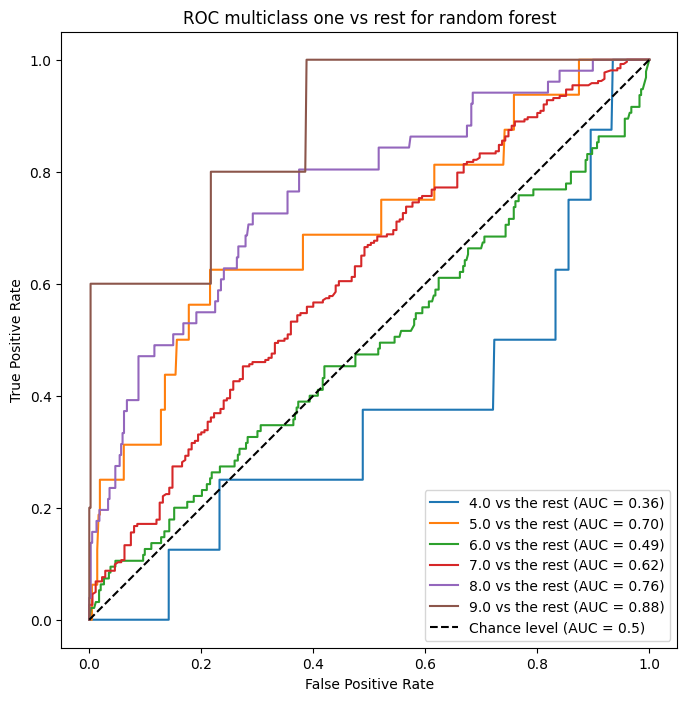

In [86]:
label_binarizer = LabelBinarizer().fit(y_resampled)
y_onehot_test = label_binarizer.transform(Y_test)
y_onehot_test.shape
y_score = estimator2.best_estimator_.fit(X_resampled, y_resampled).predict_proba(X_test)

fig, ax=plt.subplots(figsize=(8,8))
#colors = cycle(["aqua", "darkorange", "cornflowerblue","magenta","green","red"])
for c in klase:
    class_of_interest = c
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]

    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_score[:, class_id],
        name=f"{class_of_interest} vs the rest",
        plot_chance_level=(class_id==5),
        ax=ax
    )
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC multiclass one vs rest for random forest")
plt.legend()
plt.show()

In [87]:
macro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="macro",
)
micro_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="micro",
)
weighted_avg=roc_auc_score(    Y_test,
    y_score,
    multi_class="ovr",
    average="weighted",
)

print(f"Macro average auc score: {macro_avg}")
print(f"Micro average auc score: {micro_avg}")
print(f"Weightedaverage auc score: {weighted_avg}")

Macro average auc score: 0.6337701056287576
Micro average auc score: 0.7038400992473052
Weightedaverage auc score: 0.606042171485665


Najlbolje performanske sveukupno su dali random forest i dtc sa podesenim hiperparametrima

In [88]:
estimator2.best_estimator_.fit(X_resampled,y_resampled)

RandomForestClassifier(max_depth=10, n_estimators=300)

In [92]:
import joblib
joblib.dump(estimator2.best_estimator_, r'C:\Users\Administrator\2023_Data_Mining_Coffee_Quality_Dataset\models\classification\random_forest.pkl')

['C:\\Users\\Administrator\\2023_Data_Mining_Coffee_Quality_Dataset\\models\\classification\\random_forest.pkl']

In [93]:
estimator.best_estimator_.fit(X_resampled, y_resampled)

DecisionTreeClassifier(max_depth=8)

In [94]:
joblib.dump(estimator.best_estimator_, r'C:\Users\Administrator\2023_Data_Mining_Coffee_Quality_Dataset\models\classification\decision_tree.pkl')

['C:\\Users\\Administrator\\2023_Data_Mining_Coffee_Quality_Dataset\\models\\classification\\decision_tree.pkl']